In [1]:
from __future__ import division, print_function

import time
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt

import sncosmo
from astropy.table import Table

# Used to normalise features
from sklearn.preprocessing import StandardScaler 
# Used for hyperparameter optimisation and to avoid overfitting
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

# Some example algorithms you can try using (sklearn has many more)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from astropy.cosmology import Planck15 as cosmo 
from astropy.io import fits
%matplotlib inline

In [2]:
sn_machine='/Users/mariavincenzi/PhD/SNChallenge/supernova-machine/'

from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import time

import sys
import os
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
max_ml_algorithms_file=sn_machine+'max_ml_algorithms.py'
sys.path.append(os.path.dirname(os.path.expanduser(max_ml_algorithms_file)))
import max_ml_algorithms as ml_algorithms#, max_tools as tools
max_tools_file=sn_machine+'max_tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(max_tools_file)))
import max_tools as tools

/Users/mariavincenzi/anaconda2_7/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/mariavincenzi/anaconda2_7/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/mariavincenzi/anaconda2_7/lib/python2.7/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This 

In [3]:
def prepare_data4ml_algorithms(feats_file, which_feat, which_feat_err):
    f = np.array(feats_file[:, which_feat], dtype='float')
    err = np.array(feats_file[:, which_feat_err], dtype='float')
    types = np.array(feats_file[:, 1], dtype='int')

    X = f[types!=-9, :]
    Y = types[types!=-9]
    X_err = err[types!=-9, :]

    X_scaled, X_err_scaled, mean,std= tools.scale_data_with_errors(X, X_err)
    X_combined = np.concatenate((X_scaled, X_err_scaled), axis=1)

    #Combine classes into Ia (Y=1), II (Y=2), and Ib and Ic (Y=3)
    Y[(Y==21) | (Y==22) | (Y==23)]=2
    Y[(Y==32) | (Y==33)]=3
    
    return X_combined, Y, X_scaled.shape[1], mean, std

def scale_data(X, m=[None], std=[None], ret=False):
    """
    Scale all data to be distributed about mean = 0 with std = 1. Scale the feature errors by the 
    same factor.
    
    INPUTS:
    X - An array containing all the features, of size (N_samples, N_features)
    
    OUTPUTS:
    X_scaled - An array containing all scaled features, of size (N_samples, N_features)
    """
    if len(m)==4:
        sigma = std
        mean = m
    else:
        sigma = np.std(X, axis=0)
        mean = np.mean(X, axis=0)

    X_scaled = -999*np.ones(X.shape)
    
    for counter in np.arange(len(sigma)):
        X_scaled[:, counter] = (X[:, counter]-mean[counter]*np.ones(X.shape[0]))/sigma[counter]
    
    if ret:
        return X_scaled, mean, sigma
    else:
        return X_scaled



In [4]:
def run_ml_plot(X_combined, Y, Shape):
    #Preallocate results table for multiple runs
    #NOTE I'M HARD CODING THE NUMBER OF CLASSIFIERS AND PERFORMANCE
    #CRITERION HERE
    N_runs = 1
    N_classifiers = 7
    N_scores = 3
    results = -999*np.ones([N_classifiers, N_scores, N_runs])
    thresholds = -999*np.ones([N_classifiers, N_scores-1, N_runs])

    #Run classifiers and return AUC, FoM and F1 for each
    for run_counter in np.arange(N_runs):
       
        X_train_combined, X_test_combined, Y_train, Y_test = train_test_split(
        X_combined, Y, test_size=0.5, random_state=np.random.randint(100))
        
        #Seperate features and errors again
        X_train = X_train_combined[:, :Shape]
        X_train_err = X_train_combined[:, Shape:]
        X_test = X_test_combined[:, :Shape]
        X_test_err = X_test_combined[:, Shape:]
        
        #Run classifiers
        results_temp, thresholds_temp, P_RF_test, P_RF_train = tools.run_ml(X_train, Y_train, X_test, Y_test, X_train_err, X_test_err)
        results[:, :, run_counter] = results_temp
        thresholds[:, :, run_counter] = thresholds_temp
        
        #Clean up a bit
        del results_temp, thresholds_temp, X_train_combined, X_test_combined
        
    return results, thresholds, P_RF_test, P_RF_train, X_test, X_test_err, Y_test, X_train, X_train_err, Y_train




In [5]:
start = time.time()

feats_DESdata_file = np.genfromtxt('/Users/mariavincenzi/PhD/DES/DES_PhotClass_Y4.csv',\
                            dtype=None,names=True)


feats_DESsim_file = np.genfromtxt('/Users/mariavincenzi/PhD/SNChallenge/ml_esac/salt2_fit_train_sample_complete_log10x0_mb_cov2.txt',\
                            dtype='str', comments='#')

mb_errors=3.*np.ones(len(feats_DESsim_file))
DESsim_zspec_x1_c_mb=[26,32,34,36]
DESsim_zspec_x1_c_mb_err=[27,33,35,37]



feats_DESdata = np.vstack((feats_DESdata_file['zHD'],\
                        feats_DESdata_file['x1_fit'],\
                        feats_DESdata_file['c_fit'],\
                        feats_DESdata_file['mb_fit']))


In [6]:
feats_DESsim_file.shape

(1119, 40)

In [7]:
def results_analysis(RES_XX):
    results, thresholds, P_RF_test, P_RF_train, X_test, X_test_err, Y_test, X_train, X_train_err, Y_train = RES_XX
    #concatenate:
    X=np.concatenate([X_test, X_train])
    Y=np.concatenate([Y_test, Y_train])
    Xerr=np.concatenate([X_test_err, X_train_err])

    P_RF=np.concatenate([P_RF_test, P_RF_train])

    Res_Class=np.array([1+np.argmax([P_RF[i,0], P_RF[i,1], P_RF[i,2]])\
                             for i in range(len(Y))])

    FN_Ia=((Res_Class!=1))&(Y==1)
    FP_Ia=((Res_Class==1))&(Y!=1)
    TP_Ia=((Res_Class==1))&(Y==1)
    TN_Ia=((Res_Class!=1))&(Y!=1)
    
    print ('FP', len(Y[FP_Ia]), 'FN', len(Y[FN_Ia]))
    print ('TP', len(Y[TP_Ia]), 'TN', len(Y[TN_Ia]))

    print ('########  purity: ', np.round(100.*float(len(Y[TP_Ia]))/(len(Y[FP_Ia])+len(Y[TP_Ia]))))
    print ('########  efficiency: ', np.round(100*float(len(Y[TP_Ia]))/(len(Y[FN_Ia])+len(Y[TP_Ia]))))
    
    Res_Class_chop= np.ones(len(Y))*2
    Res_Class_chop[P_RF[:,0]>0.95]= 1 
    
    FN_Ia_c=((Res_Class_chop!=1))&(Y==1)
    FP_Ia_c=((Res_Class_chop==1))&(Y!=1)
    TP_Ia_c=((Res_Class_chop==1))&(Y==1)
    TN_Ia_c=((Res_Class_chop!=1))&(Y!=1)
    print ('FP', len(Y[FP_Ia_c]), 'FN', len(Y[FN_Ia_c]))
    print ('TP', len(Y[TP_Ia_c]), 'TN', len(Y[TN_Ia_c]))
    
    print ('########  purity chopping: ', np.round(100.*float(len(Y[TP_Ia_c]))/(len(Y[FP_Ia_c])+len(Y[TP_Ia_c]))))
    print ('########  efficiency chopping: ', np.round(100*float(len(Y[TP_Ia_c]))/(len(Y[FN_Ia_c])+len(Y[TP_Ia_c]))))
    
    
    return X, Xerr, Y, P_RF

scale_data_with_errors [  0.48640093   0.54388303   0.08178314  22.96815013] [ 0.19513524  1.55109933  0.20693884  0.86575205]
KNN optimiser time taken: 0.883414983749
('FeatImp', array([ 0.22260715,  0.35307798,  0.30490012,  0.11941475]))
('FeatImp', array([ 0.20502259,  0.31766988,  0.36029023,  0.1170173 ]))
('FeatImp', array([ 0.21425412,  0.35058592,  0.31552714,  0.11963282]))
('FeatImp', array([ 0.20489209,  0.32313427,  0.35542883,  0.1165448 ]))
('FeatImp', array([ 0.2214531 ,  0.3560264 ,  0.30174684,  0.12077366]))
('FeatImp', array([ 0.21118715,  0.3176425 ,  0.35273995,  0.1184304 ]))
('FeatImp', array([ 0.21331115,  0.35461465,  0.31168838,  0.12038582]))
('FeatImp', array([ 0.21074274,  0.31749996,  0.35293935,  0.11881795]))
('FeatImp', array([ 0.21882474,  0.35243932,  0.30708862,  0.12164732]))
('FeatImp', array([ 0.21172377,  0.31656178,  0.35397454,  0.11773991]))
RF optimisier time taken: 71.0719821453
('ARGS', (RandomForestClassifier(bootstrap=True, class_weight=

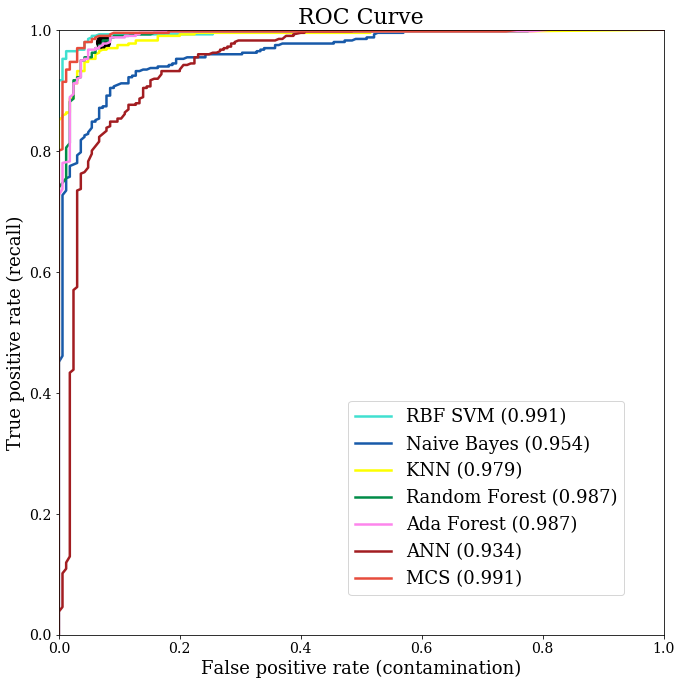

In [8]:
X_combined, Y_keys , Sh, mean_zsp, std_zsp= prepare_data4ml_algorithms(feats_DESsim_file, \
                                                                       DESsim_zspec_x1_c_mb, DESsim_zspec_x1_c_mb_err)
RES_zsp=run_ml_plot(X_combined, Y_keys, Sh)

In [9]:
X_DES, Xerr_DES, Y_DES, Prob_DES= results_analysis(RES_zsp)

FP 32 FN 20
TP 760 TN 307
########  purity:  96.0
########  efficiency:  97.0
FP 5 FN 164
TP 616 TN 334
########  purity chopping:  99.0
########  efficiency chopping:  79.0


In [10]:

X_training=np.array(np.vstack((feats_DESsim_file[:,26],\
                               feats_DESsim_file[:,32],\
                               feats_DESsim_file[:,34],\
                               feats_DESsim_file[:,36],\
                              )), dtype=float).T

Y_training=np.array(feats_DESsim_file[:,1], dtype=float)
   
Y_training[(Y_training==21) | (Y_training==22) | (Y_training==23)]=2
Y_training[(Y_training==32) | (Y_training==33)]=3

X_testing=feats_DESdata.T

ARG=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
n_est=5

Combine=np.vstack((X_training, X_testing))
Combined_scaled, global_mean, global_std = scale_data(Combine, ret=True)

X_training_scaled = scale_data(X_training, global_mean, global_std)
X_testing_scaled = scale_data(X_testing, global_mean, global_std)

print (X_training.shape)
print (Y_training.shape)
print (X_testing.shape)

from sklearn.ensemble import RandomForestClassifier,  AdaBoostClassifier

classifier = AdaBoostClassifier(base_estimator = ARG, n_estimators = n_est)
    
#Train the classifier, and use it to classify the testing set
classifier.fit(X_training_scaled, Y_training)
probs=classifier.predict_proba(X_testing_scaled)    


(1119, 4)
(1119,)
(1394, 4)


In [11]:
X_testing

array([[  0.4557 ,   0.3069 ,  -0.05214,  22.416  ],
       [  0.4339 ,   2.375  ,   0.03382,  23.616  ],
       [  0.4132 ,   0.7057 ,  -0.04525,  22.205  ],
       ..., 
       [  0.2985 ,  -1.079  ,   0.2909 ,  23.797  ],
       [  0.7827 ,   0.1931 ,   0.03299,  24.074  ],
       [  0.3888 ,   0.1684 ,  -0.1015 ,  21.928  ]])

In [12]:
P_ia_ML=probs[:,0]
type_classif=np.array([1+np.argmax([probs[i,0], probs[i,1], probs[i,2]])\
                             for i in range(len(probs[:,0]))])


(array([ 1336.,    19.,    15.,     3.,     4.,     6.,     4.,     2.,
            3.,     2.]),
 array([  2.22044605e-16,   6.40000000e-02,   1.28000000e-01,
          1.92000000e-01,   2.56000000e-01,   3.20000000e-01,
          3.84000000e-01,   4.48000000e-01,   5.12000000e-01,
          5.76000000e-01,   6.40000000e-01]),
 <a list of 10 Patch objects>)

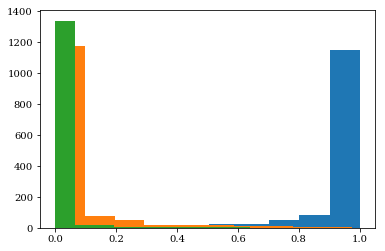

In [13]:
plt.hist(probs[:,0])
plt.hist(probs[:,1])
plt.hist(probs[:,2])

In [14]:
#boost_RF(X_train, Y_train, X_test, *args):
#ARG=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
#            max_depth=None, max_features='auto', max_leaf_nodes=None,
#            min_impurity_decrease=0.0, min_impurity_split=None,
#            min_samples_leaf=1, min_samples_split=2,
#           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
#            oob_score=False, random_state=None, verbose=0,
#            warm_start=False), 3

In [15]:
P_ia_PSNID=np.ones(len(P_ia_ML))
mu_training= X_training[:,3]+19.05+0.26*X_training[:,1]-3.*X_training[:,2]

In [16]:
X_training[:,3]

array([ 22.95,  22.17,  23.55, ...,  23.97,  22.75,  23.87])

(35.7, 45)

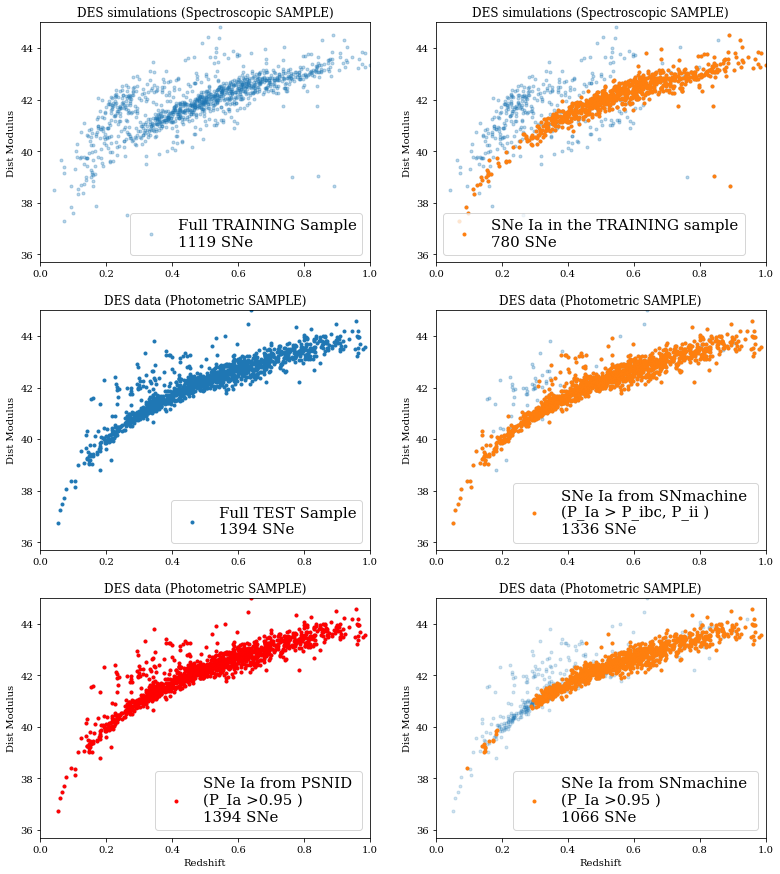

In [35]:
filterML=P_ia_ML>0.95

filterML_highestP=type_classif==1
filterPSNID=P_ia_PSNID>0.95
filtertraining= Y_training == 1


fig=plt.figure(1,figsize=(13,15))
plt.subplot(323)
plt.title('DES data (Photometric SAMPLE)')
plt.plot(feats_DESdata_file['zHD'], feats_DESdata_file['mu'],#-cosmo.distmod(feats_DESdata_file['zHD']).value,\
         '.', label='Full TEST Sample\n%i SNe'%len(feats_DESdata_file['mu']))
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1)
plt.ylim(35.7,45)#(-3,3)
plt.subplot(326)
plt.title('DES data (Photometric SAMPLE)')
plt.plot(feats_DESdata_file['zHD'], feats_DESdata_file['mu'],#-cosmo.distmod(feats_DESdata_file['zHD']).value,\
         '.', alpha=0.2)
plt.plot(feats_DESdata_file['zHD'][filterML], feats_DESdata_file['mu'][filterML],#-cosmo.distmod(feats_DESdata_file['zHD'][filterML]).value,\
         '.', label='SNe Ia from SNmachine \n(P_Ia >0.95 )\n%i SNe'%len(feats_DESdata_file['mu'][filterML]))
plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1)
plt.ylim(35.7,45)#(-3,3)

plt.subplot(321)
plt.title('DES simulations (Spectroscopic SAMPLE)')
plt.plot(X_training[:,0], mu_training,#-cosmo.distmod(X_training[:,0]).value,\
         '.', alpha=0.3, label='Full TRAINING Sample\n%i SNe'%len(mu_training))
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1)
plt.ylim(35.7,45)#(-3,3)
plt.subplot(322)
plt.title('DES simulations (Spectroscopic SAMPLE)')
plt.plot(X_training[:,0], mu_training, '.', alpha=0.3)
plt.plot(X_training[:,0][filtertraining], mu_training[filtertraining],#-cosmo.distmod(X_training[:,0][filtertraining]).value,\
         '.', label='SNe Ia in the TRAINING sample\n%i SNe'%len(mu_training[filtertraining]))
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1)
plt.ylim(35.7,45)#(-3,3)

plt.subplot(325)
plt.title('DES data (Photometric SAMPLE)')
plt.plot(feats_DESdata_file['zHD'], feats_DESdata_file['mu'], '.', alpha=0.3)
plt.plot(feats_DESdata_file['zHD'][filterPSNID], feats_DESdata_file['mu'][filterPSNID],#-cosmo.distmod(feats_DESdata_file['zHD'][filterPSNID]).value,\
         'r.', label='SNe Ia from PSNID \n(P_Ia >0.95 )\n%i SNe'%len(feats_DESdata_file['mu'][filterPSNID]))
plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1)
plt.ylim(35.7,45)#(-3,3)


plt.subplot(324)
plt.title('DES data (Photometric SAMPLE)')
plt.plot(feats_DESdata_file['zHD'], feats_DESdata_file['mu'], '.', alpha=0.3)
plt.plot(feats_DESdata_file['zHD'][filterML_highestP], feats_DESdata_file['mu'][filterML_highestP],#-cosmo.distmod(feats_DESdata_file['zHD'][filterML_highestP]).value,\
         '.', label='SNe Ia from SNmachine \n(P_Ia > P_ibc, P_ii )\n%i SNe'%len(feats_DESdata_file['mu'][filterML_highestP]))
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1)
plt.ylim(35.7,45)#(-3,3)



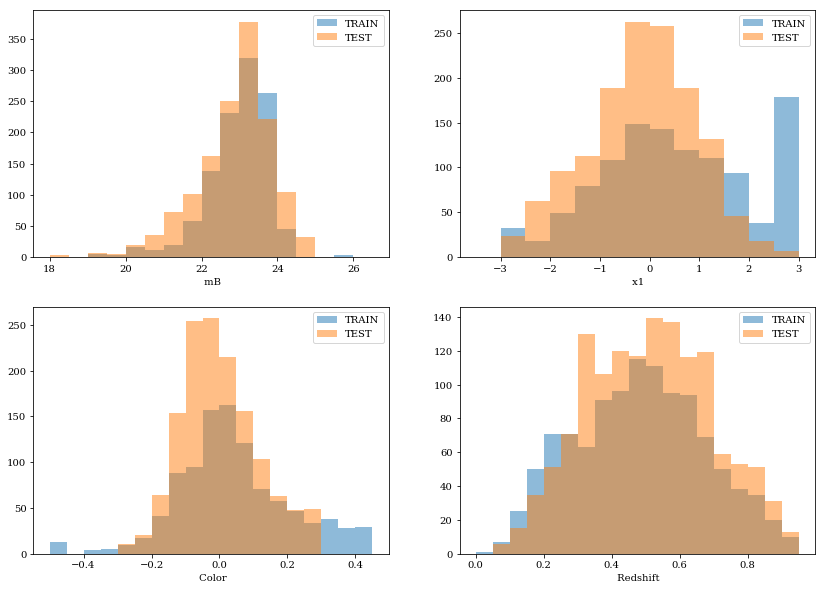

In [18]:
fig=plt.figure(1, figsize=(14,10))
b=np.arange(18,27,0.5)
plt.subplot(221)
plt.hist(X_training[:,3], alpha=0.5, bins=b, label='TRAIN')
plt.hist(X_testing[:,3], alpha=0.5, bins=b, label='TEST')
plt.xlabel(' mB')
plt.legend()
plt.subplot(222)
b=np.arange(-3.5,+3.5,0.5)
plt.hist(X_training[:,1], alpha=0.5, bins=b, label='TRAIN')
plt.hist(X_testing[:,1], alpha=0.5, bins=b, label='TEST')
plt.xlabel(' x1')
plt.legend()
plt.subplot(223)
b=np.arange(-0.5,+0.5,0.05)
plt.hist(X_training[:,2], alpha=0.5, bins=b, label='TRAIN')
plt.hist(X_testing[:,2], alpha=0.5, bins=b, label='TEST')
plt.xlabel(' Color')
plt.legend()
plt.subplot(224)
b=np.arange(0,1,0.05)
plt.hist(X_training[:,0], alpha=0.5, bins=b, label='TRAIN')
plt.hist(X_testing[:,0], alpha=0.5, bins=b, label='TEST')
plt.xlabel(' Redshift')
plt.legend()

Text(0.5,0,u'rescaled Redshift')

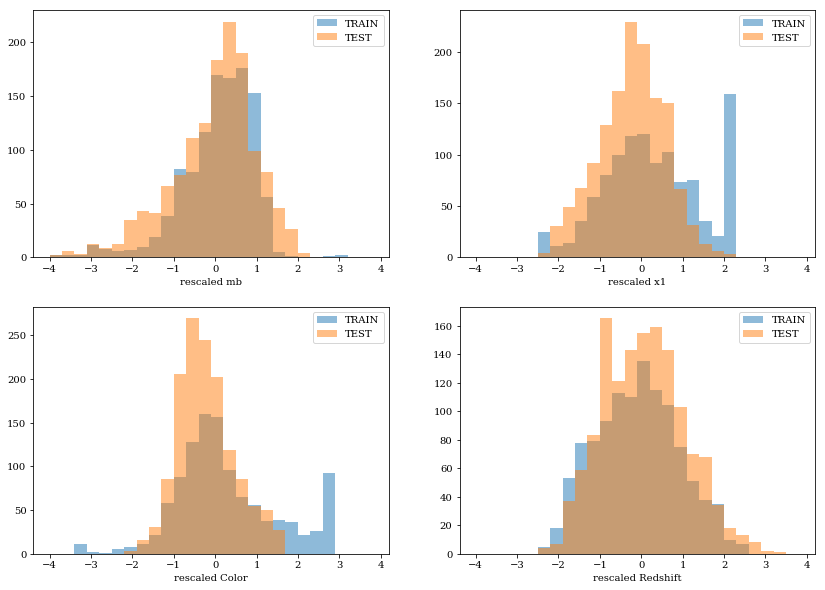

In [19]:
b=np.arange(-4,+4,0.3)
fig=plt.figure(1, figsize=(14,10))
plt.subplot(221)
plt.hist(X_training_scaled[:,3], alpha=0.5, bins=b, label='TRAIN')
plt.hist(X_testing_scaled[:,3], alpha=0.5, bins=b, label='TEST')
plt.legend()
plt.xlabel('rescaled mb')
plt.subplot(222)
plt.hist(X_training_scaled[:,1], alpha=0.5, bins=b, label='TRAIN')
plt.hist(X_testing_scaled[:,1], alpha=0.5, bins=b, label='TEST')
plt.legend()
plt.xlabel('rescaled x1')
plt.subplot(223)
plt.hist(X_training_scaled[:,2], alpha=0.5, bins=b, label='TRAIN')
plt.hist(X_testing_scaled[:,2], alpha=0.5, bins=b, label='TEST')
plt.legend()
plt.xlabel('rescaled Color')
plt.subplot(224)
plt.hist(X_training_scaled[:,0], alpha=0.5, bins=b, label='TRAIN')
plt.hist(X_testing_scaled[:,0], alpha=0.5, bins=b, label='TEST')
plt.legend()
plt.xlabel('rescaled Redshift')

In [20]:
X_training_noz=np.array(np.vstack((
                               feats_DESsim_file[:,32],\
                               feats_DESsim_file[:,34],\
                               feats_DESsim_file[:,36],\
                              )), dtype=float).T

Y_training_noz=np.array(feats_DESsim_file[:,1], dtype=float)
   
Y_training_noz[(Y_training_noz==21) | (Y_training_noz==22) | (Y_training_noz==23)]=2
Y_training_noz[(Y_training_noz==32) | (Y_training_noz==33)]=3

feats_DES_noz = np.vstack((
                        feats_DESdata_file['x1_fit'], \
                        feats_DESdata_file['c_fit'],\
                        feats_DESdata_file['mb_fit']))


X_testing_noz=feats_DES_noz.T

ARG=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
n_est=5

Combine=np.vstack((X_training_noz, X_testing_noz))
Combined_scaled, global_mean, global_std = scale_data(Combine, ret=True)

X_training_noz_scaled = scale_data(X_training_noz, global_mean, global_std)
X_testing_noz_scaled = scale_data(X_testing_noz, global_mean, global_std)

print (X_training_noz.shape)
print (Y_training_noz.shape)
print (X_testing_noz.shape)

from sklearn.ensemble import RandomForestClassifier,  AdaBoostClassifier

classifier = AdaBoostClassifier(base_estimator = ARG, n_estimators = n_est)
    
#Train the classifier, and use it to classify the testing set
classifier.fit(X_training_noz_scaled, Y_training_noz)
probs_noz=classifier.predict_proba(X_testing_noz_scaled)    



(1119, 3)
(1119,)
(1394, 3)


In [21]:
P_ia_ML_noz=probs_noz[:,0]
type_classif_noz=np.array([1+np.argmax([probs_noz[i,0], probs_noz[i,1], probs_noz[i,2]])\
                             for i in range(len(probs_noz[:,0]))])


(35.7, 45)

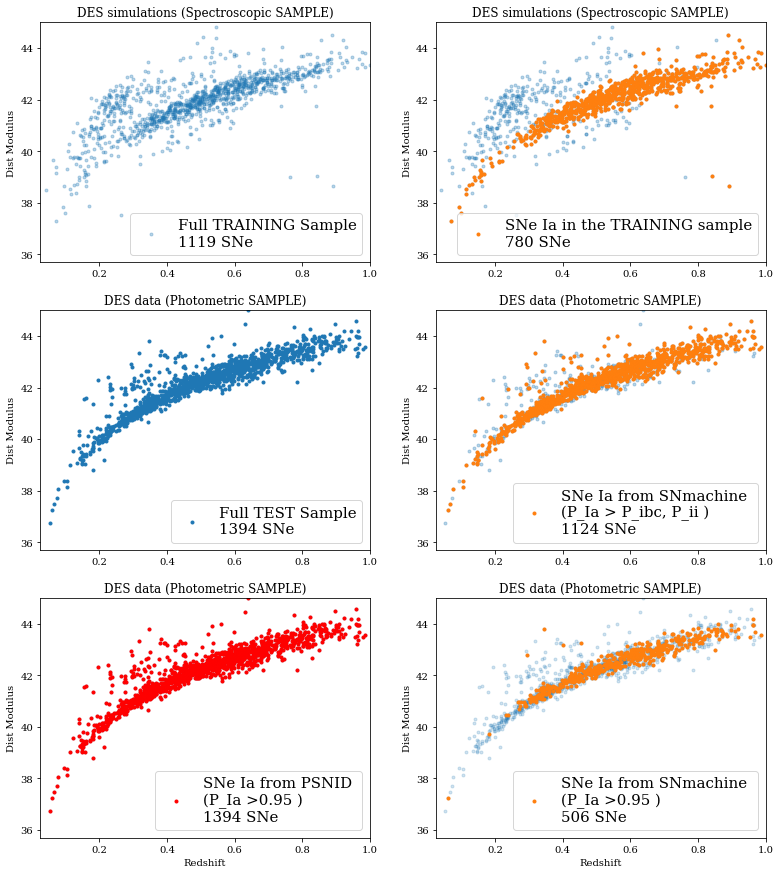

In [37]:
#### 

filterML_noz=P_ia_ML_noz>0.95
filterML_highestP_noz=type_classif_noz==1
filterPSNID_noz=P_ia_PSNID>0.95
filtertraining_noz= Y_training_noz == 1


fig=plt.figure(1,figsize=(13,15))
plt.subplot(323)
plt.title('DES data (Photometric SAMPLE)')
plt.plot(feats_DESdata_file['zHD'], feats_DESdata_file['mu'],\
         '.', label='Full TEST Sample\n%i SNe'%len(feats_DESdata_file['mu']))
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1)
plt.ylim(35.7,45)
#plt.xscale('log')

plt.subplot(326)
plt.title('DES data (Photometric SAMPLE)')
plt.plot(feats_DESdata_file['zHD'], feats_DESdata_file['mu'], '.', alpha=0.2)
plt.plot(feats_DESdata_file['zHD'][filterML_noz], feats_DESdata_file['mu'][filterML_noz],\
         '.', label='SNe Ia from SNmachine \n(P_Ia >0.95 )\n%i SNe'%len(feats_DESdata_file['mu'][filterML_noz]))
plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1)
plt.ylim(35.7,45)
#plt.xscale('log')

plt.subplot(321)
plt.title('DES simulations (Spectroscopic SAMPLE)')
plt.plot(X_training[:,0], mu_training, '.', alpha=0.3, \
         label='Full TRAINING Sample\n%i SNe'%len(mu_training))
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1)
plt.ylim(35.7,45)
#plt.xscale('log')

plt.subplot(322)
plt.title('DES simulations (Spectroscopic SAMPLE)')
plt.plot(X_training[:,0], mu_training, '.', alpha=0.3)
plt.plot(X_training[:,0][filtertraining_noz], mu_training[filtertraining_noz],\
         '.', label='SNe Ia in the TRAINING sample\n%i SNe'%len(mu_training[filtertraining_noz]))
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1)
plt.ylim(35.7,45)
#plt.xscale('log')

plt.subplot(325)
plt.title('DES data (Photometric SAMPLE)')
plt.plot(feats_DESdata_file['zHD'], feats_DESdata_file['mu'], '.', alpha=0.3)
plt.plot(feats_DESdata_file['zHD'][filterPSNID_noz], feats_DESdata_file['mu'][filterPSNID_noz],\
         '.r', label='SNe Ia from PSNID \n(P_Ia >0.95 )\n%i SNe'%len(feats_DESdata_file['mu'][filterPSNID_noz]))
plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1)
plt.ylim(35.7,45)
#plt.xscale('log')


plt.subplot(324)
plt.title('DES data (Photometric SAMPLE)')
plt.plot(feats_DESdata_file['zHD'], feats_DESdata_file['mu'], '.', alpha=0.3)
plt.plot(feats_DESdata_file['zHD'][filterML_highestP_noz], feats_DESdata_file['mu'][filterML_highestP_noz],\
         '.', label='SNe Ia from SNmachine \n(P_Ia > P_ibc, P_ii )\n%i SNe'%len(feats_DESdata_file['mu'][filterML_highestP_noz]))
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1)
plt.ylim(35.7,45)
#plt.xscale('log')




In [23]:
mu_training

array([ 42.3771  ,  41.0517  ,  42.462118, ...,  43.591462,  41.789876,
        43.19354 ])

In [24]:
X_training.shape

(1119, 4)

In [41]:

data_results=np.genfromtxt('/Users/mariavincenzi/PhD/SNChallenge/DES_UNBLIND_KEY/DES_UNBLIND+HOSTZ.KEY'\
                           , dtype=None, names=True)


In [55]:
### build a representative training sample
import random
feats_log10_TEST = np.genfromtxt('/Users/mariavincenzi/PhD/SNChallenge/ml_esac/salt2_fit_TEST_sample_log10x0_mb_cov.txt',\
                            dtype='str', comments='#')

filter_nan=np.where(~np.isnan(np.array(feats_log10_TEST[:,30], dtype=float)))[0]


random_indexes = np.array([random.randint(0, len(feats_log10_TEST[filter_nan])-1)\
                                       for j in range(1119)])


In [60]:
feats_log10_REPRESENTATIVE = np.array([feats_log10_TEST[filter_nan][rand_ind]\
                                       for rand_ind in random_indexes])

des_file_associated = feats_log10_REPRESENTATIVE[:,0]


In [61]:
des_file_associated

array(['DES_SN051455.DAT', 'DES_SN006714.DAT', 'DES_SN128019.DAT', ...,
       'DES_SN089791.DAT', 'DES_SN140980.DAT', 'DES_SN091136.DAT'], 
      dtype='|S16')

In [62]:

Y_TEST_REPR_results=[]
for des_snid in des_file_associated:
    try:
        CID=int((des_snid.replace('DES_SN','')).replace('.DAT',''))
        ind_corrispondent=np.where(data_results['CID']==CID)[0]
        Y_TEST_REPR_results.append(data_results['GENTYPE'][ind_corrispondent][0])
    except ValueError:
        ind_corrispondent=np.where(data_results['CID']==CID)[0]
#        print (ind_corrispondent, data_results['GENTYPE'][ind_corrispondent][0])
        print ('No type for', des_snid)
        Y_TEST_REPR_results.append(np.nan)


In [64]:
X_training_REPR=np.array(np.vstack((
                               feats_log10_REPRESENTATIVE[:,26],\
                               feats_log10_REPRESENTATIVE[:,32],\
                               feats_log10_REPRESENTATIVE[:,34],\
                               feats_log10_REPRESENTATIVE[:,36],\
                              )), dtype=float).T

Y_training_REPR=np.array(Y_TEST_REPR_results, dtype=float)
   
Y_training_REPR[(Y_training_REPR==21) | (Y_training_REPR==22) | (Y_training_REPR==23)]=2
Y_training_REPR[(Y_training_REPR==32) | (Y_training_REPR==33)]=3

feats_DES_REPR = np.vstack((
                        feats_DESdata_file['x1_fit'], \
                        feats_DESdata_file['c_fit'],\
                        feats_DESdata_file['mb_fit']))

X_testing_REPR=feats_DESdata.T

ARG=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
n_est=5

Combine=np.vstack((X_training_REPR, X_testing_REPR))
Combined_scaled, global_mean, global_std = scale_data(Combine, ret=True)

X_training_REPR_scaled = scale_data(X_training_REPR, global_mean, global_std)
X_testing_REPR_scaled = scale_data(X_testing_REPR, global_mean, global_std)

print (X_training_REPR.shape)
print (Y_training_REPR.shape)
print (X_testing_REPR.shape)

from sklearn.ensemble import RandomForestClassifier,  AdaBoostClassifier

classifier = AdaBoostClassifier(base_estimator = ARG, n_estimators = n_est)
    
#Train the classifier, and use it to classify the testing set
classifier.fit(X_training_REPR_scaled, Y_training_REPR)
probs_REPR=classifier.predict_proba(X_testing_REPR_scaled)    


(1119, 4)
(1119,)
(1394, 4)


(35.7, 45)

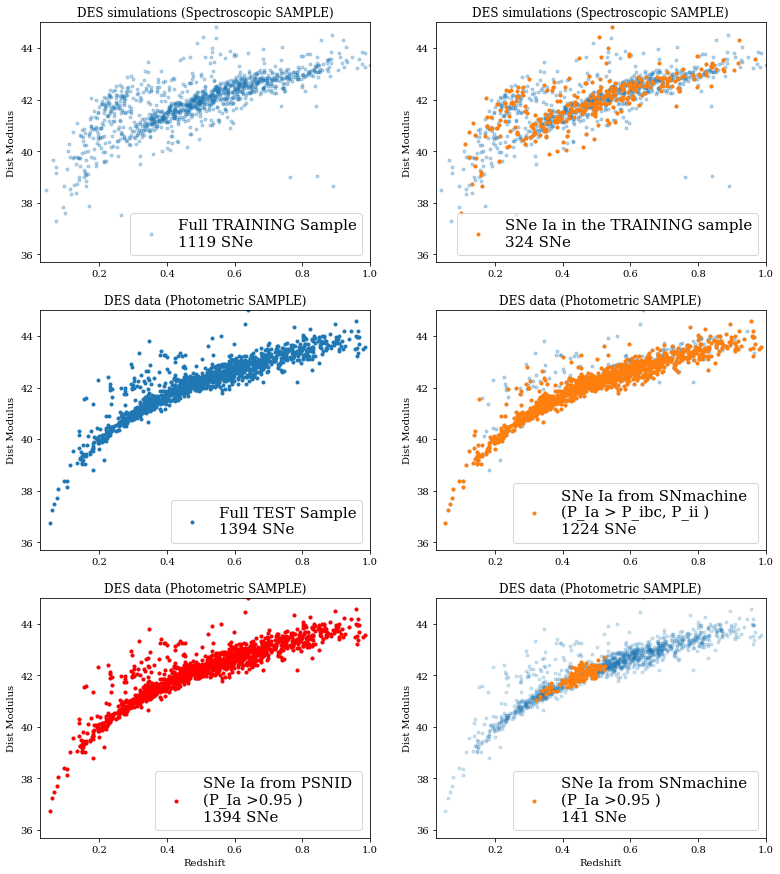

In [65]:
#### 
P_ia_ML_REPR=probs_REPR[:,0]
type_classif_REPR=np.array([1+np.argmax([probs_REPR[i,0], probs_REPR[i,1], probs_REPR[i,2]])\
                             for i in range(len(probs_REPR[:,0]))])



filterML_REPR=P_ia_ML_REPR>0.95
filterML_highestP_REPR=type_classif_REPR==1
filterPSNID_REPR=P_ia_PSNID>0.95
filtertraining_REPR= Y_training_REPR == 1


fig=plt.figure(1,figsize=(13,15))
plt.subplot(323)
plt.title('DES data (Photometric SAMPLE)')
plt.plot(feats_DESdata_file['zHD'], feats_DESdata_file['mu'],\
         '.', label='Full TEST Sample\n%i SNe'%len(feats_DESdata_file['mu']))
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1)
plt.ylim(35.7,45)
#plt.xscale('log')

plt.subplot(326)
plt.title('DES data (Photometric SAMPLE)')
plt.plot(feats_DESdata_file['zHD'], feats_DESdata_file['mu'], '.', alpha=0.2)
plt.plot(feats_DESdata_file['zHD'][filterML_REPR], feats_DESdata_file['mu'][filterML_REPR],\
         '.', label='SNe Ia from SNmachine \n(P_Ia >0.95 )\n%i SNe'%len(feats_DESdata_file['mu'][filterML_REPR]))
plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1)
plt.ylim(35.7,45)
#plt.xscale('log')

plt.subplot(321)
plt.title('DES simulations (Spectroscopic SAMPLE)')
plt.plot(X_training[:,0], mu_training, '.', alpha=0.3, \
         label='Full TRAINING Sample\n%i SNe'%len(mu_training))
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1)
plt.ylim(35.7,45)
#plt.xscale('log')

plt.subplot(322)
plt.title('DES simulations (Spectroscopic SAMPLE)')
plt.plot(X_training[:,0], mu_training, '.', alpha=0.3)
plt.plot(X_training[:,0][filtertraining_REPR], mu_training[filtertraining_REPR],\
         '.', label='SNe Ia in the TRAINING sample\n%i SNe'%len(mu_training[filtertraining_REPR]))
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1)
plt.ylim(35.7,45)
#plt.xscale('log')

plt.subplot(325)
plt.title('DES data (Photometric SAMPLE)')
plt.plot(feats_DESdata_file['zHD'], feats_DESdata_file['mu'], '.', alpha=0.3)
plt.plot(feats_DESdata_file['zHD'][filterPSNID_REPR], feats_DESdata_file['mu'][filterPSNID_REPR],\
         '.r', label='SNe Ia from PSNID \n(P_Ia >0.95 )\n%i SNe'%len(feats_DESdata_file['mu'][filterPSNID_REPR]))
plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1)
plt.ylim(35.7,45)
#plt.xscale('log')


plt.subplot(324)
plt.title('DES data (Photometric SAMPLE)')
plt.plot(feats_DESdata_file['zHD'], feats_DESdata_file['mu'], '.', alpha=0.3)
plt.plot(feats_DESdata_file['zHD'][filterML_highestP_REPR], feats_DESdata_file['mu'][filterML_highestP_REPR],\
         '.', label='SNe Ia from SNmachine \n(P_Ia > P_ibc, P_ii )\n%i SNe'%len(feats_DESdata_file['mu'][filterML_highestP_REPR]))
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1)
plt.ylim(35.7,45)
#plt.xscale('log')



